# FluxGate
This notebook is designed to invert for thickness across a flux gate, assuming mass conservation

Brandon S. Tober

20220601

What we have:
1) X and Y surface velocity components from ITS_LIVE - polar stereo projection
2) upglacier flux gate from Groundhog radar data containing ice thickness along a profile in the amphiteatre just above the entrance to the out - geographic coords

In [1]:
### imports ##
import os, sys, math
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import LineString, Point
from shapely.ops import unary_union 
import rasterio as rio
import numpy as np
import pyproj
import verde as vd
from scipy.interpolate import CubicSpline
plt.rcParams["font.family"] = "Calibri"
plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 8

In [2]:
### functions ###

# get distance along x,y arrays
def euclid_dist(xarray, yarray, zarray = None):
    if zarray is None:
        zarray = np.zeros_like(xarray)
    dist = np.zeros_like(xarray)
    dist[1:] = np.cumsum(np.sqrt(np.diff(xarray) ** 2.0 + np.diff(yarray) ** 2.0) + np.diff(zarray) ** 2.0)
    return dist

# generate equidistant points betwen two points
def equidistant_pts(pt0, pt1, step):
    # first convert endpoints to shapely linestring
    line = LineString((pt0, pt1))
    # n = 7
    # or to get the distances closest to the desired one:
    n = round(line.length / step)
    distances = np.linspace(0, line.length, n)
    points = [line.interpolate(distance) for distance in distances] + [Point((line.coords[-1][0], line.coords[-1][1]))]
    multipoint = unary_union(points)  # or new_line = LineString(points)
    coords = [(p.x, p.y) for p in multipoint.geoms]
    return np.column_stack(coords).T

    # make sure vx and vy rasters are same size and extent
def check_rasters(r1, r2):
    if r1.transform != r2.transform:
        return(0)
    if r1.shape != r2.shape:
        return(0)
    return(1)

Ingest radar data

In [26]:
# load up radar picks
dat_path = 'C:/Users/btober/OneDrive/Documents/MARS/targ/modl/mass_con/ruth/data/'

In [27]:
e_gate = gpd.read_file(dat_path + 'e_trib_gate.gpkg')
w_gate = gpd.read_file(dat_path + 'w_trib_gate.gpkg')
e_gate.head()

,track,trace,lon,lat,elev,srf_sample,srf_twtt,srf_elev,srf_amp,bed_sample,bed_twtt,bed_amp,bed_elev,srf_bed_thick,geometry
0,20220506_204929,22,-150.695129,62.993500,1621.609985,33.0,0.000002,1621.609985,4.797641,143.0,0.000007,-4.214607,1128.661542,492.948444,POINT (-150.69513 62.99350)
1,20220506_204929,23,-150.695236,62.993498,1621.794861,33.0,0.000002,1621.794861,18.660414,144.0,0.000007,-4.892208,1124.345573,497.449288,POINT (-150.69524 62.99350)
2,20220506_204929,24,-150.695320,62.993502,1621.916931,33.0,0.000002,1621.916931,29.673967,145.0,0.000007,-4.784956,1120.236545,501.680386,POINT (-150.69532 62.99350)
3,20220506_204929,25,-150.695404,62.993505,1621.898621,33.0,0.000002,1621.898621,13.193009,145.0,0.000007,-2.229187,1120.212433,501.686188,POINT (-150.69540 62.99351)
4,20220506_204929,26,-150.695473,62.993511,1621.918945,33.0,0.000002,1621.918945,20.134436,146.0,0.000007,-1.894183,1115.980087,505.938858,POINT (-150.69547 62.99351)


In [28]:
# make sure no nans
e_gate = e_gate.rename(columns ={'srf_bed_thick':'h'})
w_gate = w_gate.rename(columns ={'srf_bed_thick':'h'})
e_gate = e_gate[~e_gate.h.isna()]
w_gate = w_gate[~w_gate.h.isna()]

Load hillshade for nice plots

In [29]:
# load hillshade for nice plotting
hs_ds = rio.open(dat_path + "IFSAR_ruth_hs_3413.tif", "r")

hs = hs_ds.read(1)
hs[hs==-9999] = np.nan
bounds = hs_ds.bounds
hs_extent=[bounds[0],bounds[2],bounds[1],bounds[3]]

Load velocity data

In [30]:
# load up Vx, Vy - these should be in units of meters per year
vx_ds = rio.open(dat_path + "ALA_G0120_0000_vx_clip.tif", "r")
vy_ds = rio.open(dat_path + "ALA_G0120_0000_vy_clip.tif", "r")
# rastio.crs.to_epsg is not working for these geotifs, but we know they're projected to 3414
epsg = 3413
# check that rasters are same extent
check_rasters(vx_ds, vy_ds)

# factor relating dept-averaged velocity to observed surface velocity
gamma = 0.9

In [31]:
# projet radar data to same coordinate sys as velocity data
e_gate = e_gate.to_crs(epsg=epsg)
w_gate = w_gate.to_crs(epsg=epsg)
e_gate["x"] = e_gate.centroid.x
e_gate["y"] = e_gate.centroid.y
w_gate["x"] = w_gate.centroid.x
w_gate["y"] = w_gate.centroid.y

# order both gates by increasing x-dimension
e_gate = e_gate.sort_values(["x"], ascending=True)
w_gate = w_gate.sort_values(["x"], ascending=True)

In [32]:
# define end points to which we'll extrapolate thickness to zero
e_pt0 = (-2868415 , 804989)
e_pt1 = (-2866714, 807461)

w_pt0 = (-2869123, 809364)
w_pt1 = (-2866711, 807737)

In [37]:
# get temporary x-y coordinates of thickness measuremnts with added endpoints
tmp_x_e = np.append(e_pt0[0], e_gate.x.to_numpy())
tmp_x_e = np.append(tmp_x_e, e_pt1[0])
tmp_y_e = np.append(e_pt0[1], e_gate.y.to_numpy())
tmp_y_e = np.append(tmp_y_e, e_pt1[1])

tmp_x_w = np.append(w_pt0[0], w_gate.x.to_numpy())
tmp_x_w = np.append(tmp_x_w, w_pt1[0])
tmp_y_w = np.append(w_pt0[1], w_gate.y.to_numpy())
tmp_y_w = np.append(tmp_y_w, w_pt1[1])

# get cumulative distance along each profile
e_dist = euclid_dist(tmp_x_e, tmp_y_e)
w_dist = euclid_dist(tmp_x_w, tmp_y_w)

# temp thickness
tmp_h_e = np.append(0, e_gate.h.to_numpy())
tmp_h_e = np.append(tmp_h_e, 0)

tmp_h_w = np.append(0, w_gate.h.to_numpy())
tmp_h_w = np.append(tmp_h_w, 0)

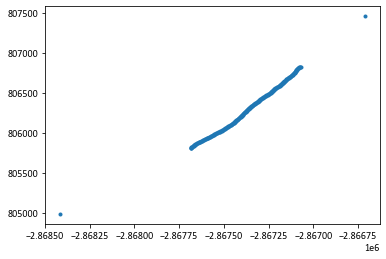

In [38]:
plt.plot(tmp_x_e,tmp_y_e,'.')

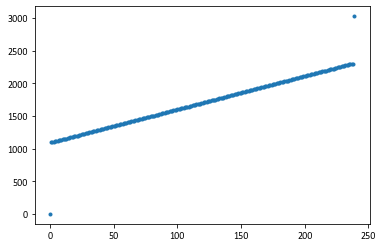

In [42]:
plt.plot(e_dist,'.')

Text(0, 0.5, 'Northing (m)')

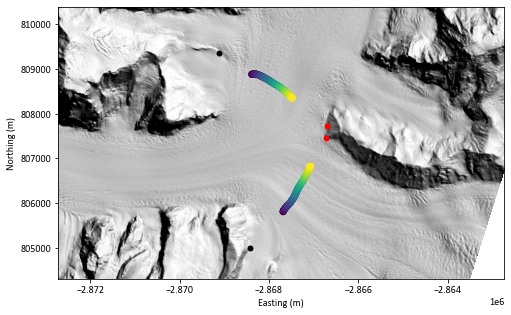

In [43]:
fig,ax = plt.subplots(1,figsize=(8,5))
s=10

ax.imshow(hs,extent=hs_extent,cmap=plt.cm.gray)
# plotting sorted by position just to make sure we're sorted properly
ax.scatter(w_gate.x, w_gate.y, cmap = 'viridis', c=np.arange(0,len(w_gate)))
ax.scatter(e_gate.x, e_gate.y, cmap = 'viridis', c=np.arange(0,len(e_gate)))

ax.plot(e_pt0[0],e_pt0[1],'.k',ms=s)
ax.plot(e_pt1[0],e_pt1[1],'.r',ms=s)
ax.plot(w_pt0[0],w_pt0[1],'.k',ms=s)
ax.plot(w_pt1[0],w_pt1[1],'.r',ms=s)
ax.axis('equal')

# auto equal extent
xmin = min(np.nanmin(w_gate.x), np.nanmin(e_gate.x))
xmax = max(np.nanmax(w_gate.x), np.nanmax(e_gate.x))
ymin = min(np.nanmin(w_gate.y), np.nanmin(e_gate.y))
ymax = max(np.nanmax(w_gate.y), np.nanmax(e_gate.y))

xdiff = xmax - xmin
ydiff = ymax - ymin

corners = [(xmin,ymax), (xmax,ymax), (xmax, ymin), (xmin,ymin)]

xs = [p[0] for p in corners]
ys = [p[1] for p in corners]
ctr = (sum(xs) / len(corners), sum(ys) / len(corners))

diff = max(xdiff, ydiff)/2 + 1.5e3

ax.set_xlim([ctr[0]-diff, ctr[0]+diff])
ax.set_ylim([ctr[1]-diff, ctr[1]+diff])

ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')

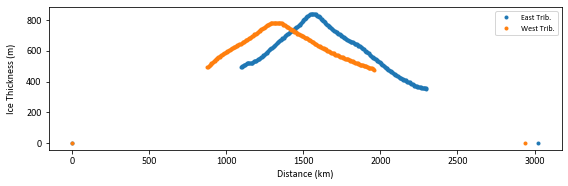

In [48]:
# plot profile thickness
fig,ax = plt.subplots(1,figsize=(8,5))

ax.plot(e_dist,tmp_h_e,'.',label='East Trib.')
ax.plot(w_dist,tmp_h_w,'.',label='West Trib.')
ax.legend()
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Ice Thickness (m)', labelpad=10)
ax.set_aspect('equal')

fig.tight_layout()

Okay - no we'll interpolate from thickness measuremnts to the endpoints shown above

In [52]:
# use verde to reduce along track radar data 
spacing=100 # m block size
reducer = vd.BlockReduce(np.mean, spacing=spacing)
(x_e, y_e), h_e = reducer.filter((e_gate.x.to_numpy(), e_gate.y.to_numpy()), e_gate.h.to_numpy())
e_trib = np.column_stack((x_e,y_e,h_e))
e_trib = e_trib[e_trib[:, 0].argsort()]


(x_w, y_w), h_w = reducer.filter((w_gate.x.to_numpy(), w_gate.y.to_numpy()), w_gate.h.to_numpy())
w_trib = np.column_stack((x_w,y_w,h_w))
w_trib = w_trib[w_trib[:, 0].argsort()]


In [53]:
# extrapolate tail coordinates - this is kind of messy and there's probably a better way to do this
#  but basically we're just taking the known thickness profiles
# and extrapolating to zero on at either end
#########################################
########## east trib, tail one ##########
#########################################
new_pts = np.asarray(equidistant_pts(
                                    e_pt0,
                                    (e_trib[0,0], e_trib[0,1]),
                                    spacing
                                    ))[:-1,:]

x_e = np.append(new_pts[:,0], e_trib[:,0])

y_e = np.append(new_pts[:,1], e_trib[:,1])

tmp = np.append(0, np.repeat(np.nan, len(new_pts) - 1))
h_e = np.append(tmp, e_trib[:,2])

########## east trib, tail two ##########
new_pts = np.asarray(equidistant_pts(
                                    (x_e[-1], y_e[-1]),
                                    e_pt1,
                                    spacing
                                    ))[1:,:]

x_e = np.append(x_e, new_pts[:,0])

y_e = np.append(y_e, new_pts[:,1])

tmp = np.append(h_e, np.repeat(np.nan, len(new_pts) - 1))
h_e = np.append(tmp, 0)


#########################################
########## west trib, tail one ##########
#########################################
new_pts = np.asarray(equidistant_pts(
                                    w_pt0,
                                    (w_trib[0,0], w_trib[0,1]),
                                    spacing
                                    ))[:-1,:]

x_w = np.append(new_pts[:,0], w_trib[:,0])

y_w = np.append(new_pts[:,1], w_trib[:,1])

tmp = np.append(0, np.repeat(np.nan, len(new_pts) - 1))
h_w = np.append(tmp, w_trib[:,2])

########## west trib, tail two ##########
new_pts = np.asarray(equidistant_pts(
                                    (x_w[-1], y_w[-1]),
                                    w_pt1,
                                    spacing
                                    ))[1:,:]

x_w = np.append(x_w, new_pts[:,0])

y_w = np.append(y_w, new_pts[:,1])

tmp = np.append(h_w, np.repeat(np.nan, len(new_pts) - 1))
h_w = np.append(tmp, 0)

In [54]:
# get distance along each profile
e_dist = euclid_dist(x_e, y_e)
w_dist = euclid_dist(x_w, y_w)

Interpolate from end of gpr profile to trib edges - based on the shape here, we'll just do linear, but could do cubic spline or something else if desired

In [55]:
# e trib
xp = e_dist[~np.isnan(h_e)]
fp = h_e[~np.isnan(h_e)]
h_e = np.interp(e_dist, xp, fp)

# w trib
xp = w_dist[~np.isnan(h_w)]
fp = h_w[~np.isnan(h_w)]
h_w = np.interp(w_dist, xp, fp)

Get ice flux from each tributary

Ice flux for a segment $(dx,dy)$ is $h*(vy*dx-vx*dy)$, where $dx$ is the x-distance between consecutive points, $dy$ is the y-distance between consecutive points, $h$ is the ice thickness at a given point, $vx$ is the x-component of velocity, and $vy$ is the y-component of velocity.

In [56]:
# get dx, dy for each trib
dx_e = np.diff(x_e)
dy_e = np.diff(y_e)
dx_w = np.diff(x_w)
dy_w = np.diff(y_w)

# get cumulative distance
dist_e = np.cumsum(np.sqrt(dx_e**2+dy_e**2))
dist_w = np.cumsum(np.sqrt(dx_w**2+dy_w**2))

# get x,y,h between each pair of points
x_e = (x_e[:-1] + x_e[1:])/2
y_e = (y_e[:-1] + y_e[1:])/2
h_e = (h_e[:-1] + h_e[1:])/2

x_w = (x_w[:-1] + x_w[1:])/2
y_w = (y_w[:-1] + y_w[1:])/2
h_w = (h_w[:-1] + h_w[1:])/2

Sample vx, vy

In [57]:
# Now sample x and y components of surface velocity at each radar pick location
coords = [(x,y) for x, y in zip(x_e,y_e)]
vx_e = np.asarray([x[0] for x in vx_ds.sample(coords)])
vy_e = np.asarray([x[0] for x in vy_ds.sample(coords)])

coords = [(x,y) for x, y in zip(x_w,y_w)]
vx_w = np.asarray([x[0] for x in vx_ds.sample(coords)])
vy_w = np.asarray([x[0] for x in vy_ds.sample(coords)])

Get ice flux

In [58]:
# multiply velocity by x and y dimensions to get area per year through each point
q_ovr_h_e =  np.abs((vx_e*dy_e) - (vy_e*dx_e))* gamma               # [m^2/yr]
q_in_e_ = h_e * q_ovr_h_e                                        # [m^3/yr]
q_in_e = np.sum(q_in_e_)

q_ovr_h_w =  np.abs((vx_w*dy_w) - (vy_w*dx_w))* gamma               # [m^2/yr]
q_in_w_ = h_w * q_ovr_h_w                                        # [m^3/yr]
q_in_w = np.sum(q_in_w_)

In [59]:
q_in = q_in_e + q_in_w

In [60]:
print(f"{q_in*1e-9} cubic kilometers of ice per year")

0.21794537513768036 cubic kilometers of ice per year


In [61]:
#stack x,y,vx,vy for plotting same scales
i = 2   # iterator
x = np.append(x_e,x_w)
y = np.append(y_e,y_w)
h = np.append(h_e,h_w)
vx = np.append(vx_e,vx_w)
vy = np.append(vy_e,vy_w)

vx[::i] = np.nan
vy[::i] = np.nan

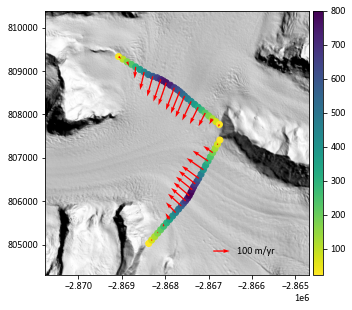

In [62]:
fig,ax = plt.subplots(1,figsize=(5,5))
vmin = min(np.nanmin(h_e), np.nanmin(h_w))
vmax = max(np.nanmax(h_e), np.nanmax(h_w))
vmax=800

ax.imshow(hs,extent=hs_extent,cmap=plt.cm.gray)
ax.scatter(x_e,y_e,c=h_e,cmap = 'viridis_r', vmin=vmin, vmax=vmax)
c = ax.scatter(x_w,y_w,c=h_w,cmap = 'viridis_r', vmin=vmin, vmax=vmax)
q = ax.quiver(x,y,vx,vy,color='r',width=.005)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='4%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')
ax.quiverkey(q,  X=0.7, Y=.09, U=100,
             label='100 m/yr', labelpos='E', coordinates = 'axes')

# auto equal extent
xmin = min(np.nanmin(w_gate.x), np.nanmin(e_gate.x))
xmax = max(np.nanmax(w_gate.x), np.nanmax(e_gate.x))
ymin = min(np.nanmin(w_gate.y), np.nanmin(e_gate.y))
ymax = max(np.nanmax(w_gate.y), np.nanmax(e_gate.y))

xdiff = xmax - xmin
ydiff = ymax - ymin

corners = [(xmin,ymax), (xmax,ymax), (xmax, ymin), (xmin,ymin)]

xs = [p[0] for p in corners]
ys = [p[1] for p in corners]
ctr = (sum(xs) / len(corners), sum(ys) / len(corners))

diff = max(xdiff, ydiff)/2 + 1.5e3

ax.set_xlim([ctr[0]-diff, ctr[0]+diff])
ax.set_ylim([ctr[1]-diff, ctr[1]+diff])

fig.tight_layout()


Viola, we have our input flux.

Now let's calculate downstream thickness across serveral flux gates

First - a function to get flux along a cross flow profile

In [67]:
def get_unique_vel_pts(coords, vx, vy):
    # we want the unique velocity field cell indices which are crossed by the flux gate
    # first get the indices of each coordinate pair in the raster
    idxs = [vx_ds.index(pair[0],pair[1]) for pair in coords]
    # now get the unique indices using dict.fromkeys() + list()
    un_idxs = list(dict.fromkeys(idxs))
    # get index of each unique index pair from the original list
    un_idxs = [idxs.index(pair) for pair in un_idxs]
    # now get unique coordinates
    un_coords = [coords[id] for id in un_idxs]
    # # get x and y separate coords
    x_out = np.asarray([x[0] for x in un_coords])
    y_out = np.asarray([x[1] for x in un_coords])
    un_coords = np.column_stack((x_out,y_out))
    return(un_coords)


def  discretized_flux(p0 = None, p1 = None, vx = None, vy = None, shape = "rectangle", a = 100):
    """
    discretized_flux is a method to get the discretized ice flux through glacial valley assuming the valley takes on a given shape

    currently this is setup to handle a rectangular shaped valley, paraboloci, and ellipse shaped valley

    for each bin, the area will be multiplied by the velocity of the corresponding cell in the velocity raster to get the flux through each bin

    if shape == 'rectangle':
        treat each bin as a rectangle of height a, and calculate the flux through each bin

    elif shape == 'ellipse':
        treat each bin as a rectangular section of an ellipse with major axis apex height, a

        to get the height each bin we'll use the parametric equations for an ellipse:

        x = b * \cos t = (1/2) * w cos(t), where w is the valley width and t ranges from 0 to 2 pi radians
        t = cos^{-1}(2x/w)

        y = a * sin(t)
        y = a * sin[cos^{-1}(2x/w)]

        the flux through each bin is then:
        f = A * v
        f = x * y * v

    the x-position of each rectangular bin will be taken from the distance between points, such that x = 0 is at the center of the valley

    inputs:
        p0: tuple, (x-coordinates, y-coordinate)
        p1: tuple, (x-coordinates, y-coordinate)
        vx: rasterio dataset, x velocity components
        vy: rasterio dataset, y velocity components
        shape: str, shape type (rectangle, parabola, ellipse, triangle)
        a: float, valley depth

    outputs:
        flux: np.ndarray, [npts,[xcoord,ycoord,thickness,vx,vy,flux]

    author:
        brandon s. tober, 20220715
    """
    if not isinstance(p0, tuple) or not isinstance(p1, tuple):
        print("p0, and p1 must both be tuples")
        return None
    if shape not in ["ellipse", "rectangle","parabola","triangle"]:
        print(f"Unsupported shape : {shape}")
        return None
    if not check_rasters(vx_ds, vy_ds):
        print("vx and vy rasters must be of same shape")
        return None

    # generate equidistant points across valley
    pts = equidistant_pts(p0, p1, 100)

    pts = get_unique_vel_pts(pts, vx_ds, vy_ds)

    # sort by y-coord
    pts = pts[pts[:, 1].argsort()]
    
    x_pos = pts[:,0]
    y_pos = pts[:,1]

    # get euclid distance
    dist = euclid_dist(x_pos, y_pos)
    # get total valley width
    w = dist[-1]

    # get distance at center of each bin
    dist = (dist[:-1]+dist[1:])/2

    # center distance array
    dist = dist - (dist[-1]/2)
    
    if shape=="parabola":
        # use numpy polyfit to fit two 0-thickness points and vertex
        x = np.array((-w/2,0,w/2))
        y = np.array((a,0,a))
        p = np.polyfit(x,y,2)
        y = np.polyval(p, dist)
        y = np.abs(y-a)

    elif shape=="ellipse":
        # get height of each rectangular bin
        y = a * np.sin( np.arccos(2 * dist / w) )

        # take absolute value of bin heights
        y = np.abs(y)

    elif shape=="rectangle":
        y = np.repeat(a, dist.shape)

    elif shape=="triangle":
        # two separate polyfits for left and right legs
        x_ = np.array((-w/2,0))
        y_ = np.array((0,a))
        p = np.polyfit(x_,y_,1)
        y = np.polyval(p, dist[dist<0])

        x_ = np.array((0,w/2))
        y_ = np.array((a,0))
        p = np.polyfit(x_,y_,1)
        y = np.append(y,np.polyval(p, dist[dist>=0]))


    # get delta x and delta y between each cell    
    dx = np.diff(x_pos)
    dy = np.diff(y_pos)

    # get centroid coordinates between each set of points - this is where we'll sample vx and vy
    xpos_tmp = (x_pos[:-1]+x_pos[1:])/2
    ypos_tmp = (y_pos[:-1]+y_pos[1:])/2

    coords = [(x,y) for x, y in zip(xpos_tmp, ypos_tmp)]
    # sample vx and vy at these centoid coordinates
    vx = np.asarray([x[0] for x in vx_ds.sample(coords)])
    vy = np.asarray([x[0] for x in vy_ds.sample(coords)])

    # get area through each bin per year using normal velocity
    q_ovr_h =  np.abs((vx*dy) - (vy*dx)) * gamma

    # get flux for each cell
    q = q_ovr_h * y

    # add back on endpoints
    x_out = np.append(np.append(p1[0], xpos_tmp), p0[0])
    y_out = np.append(np.append(p1[1], ypos_tmp), p0[1])
    h_out = np.append(np.append(0, y), 0)
    vx_out = np.append(np.append(np.nan, vx), np.nan)
    vy_out = np.append(np.append(np.nan, vy), np.nan)
    q_out = np.append(np.append(np.nan, q), np.nan)

    # stack
    out = np.column_stack((x_out, y_out, h_out, vx_out, vy_out, q_out))

    return out

Load in csv with endpoints for desired flux gates - manually created in qgis.

We have fields for 'num' and 'side' to define pairs of endpoints for a given flux gate

In [68]:
df = pd.read_csv(dat_path + 'gorge_prof_endpts.csv')
df.head()

,X,Y,num,side
0,-2.869151e+06,807897.384243,1,w
1,-2.868630e+06,805993.191544,1,e
2,-2.869764e+06,807680.418587,2,w
3,-2.869166e+06,805868.117225,2,e
4,-2.870361e+06,807534.923971,3,w


In [78]:
# loop through flux gate endpoints
df_e = df[df['side']=='e']
df_w = df[df['side']=='w']
shape = 'parabola'

for n in df.num.unique():
    if n not in [1,3,5,7,10]:       # just plotting several of the gates here
        continue
    # parse out endpoints for each flux gate
    p0 = tuple(df_w[df_w['num']==n][['X','Y']].values.flatten())
    p1 = tuple(df_e[df_e['num']==n][['X','Y']].values.flatten())

    # iteratively increase valley center vertex depth until qin=qout
    a = 500     # starting apex depth
    q_out = 0
    step = 1
    while q_out < q_in:

        out = discretized_flux(p0, p1, vx_ds, vy_ds, shape=shape, a=a)
        
        q_out = np.nansum(out[:,-1])

        # add to center depth until flux sums are roughly equal
        a+= step

    a-=step
    out = discretized_flux(p0, p1, vx_ds, vy_ds, shape=shape, a=a)

    #stack x,y,vx,vy for plotting same scales
    x = np.append(x,out[:,0])
    y = np.append(y,out[:,1])
    h = np.append(h,out[:,2])
    vx = np.append(vx,out[:,3])
    vy = np.append(vy,out[:,4])

    print(f"a-value = {a} meters of ice")
    print(f"Flux through {shape} = {round(q_out*1e-9,4)} cubic kilometers of ice per year")


a-value = 781 meters of ice
Flux through parabola = 0.2181 cubic kilometers of ice per year
a-value = 731 meters of ice
Flux through parabola = 0.218 cubic kilometers of ice per year
a-value = 752 meters of ice
Flux through parabola = 0.218 cubic kilometers of ice per year
a-value = 735 meters of ice
Flux through parabola = 0.2181 cubic kilometers of ice per year
a-value = 753 meters of ice
Flux through parabola = 0.2181 cubic kilometers of ice per year


Load in all radar picks for plotting

In [79]:
# load in all amp picks
# load up radar picks
tmp_rdata = gpd.read_file(dat_path + "Ruth2022_pk_bst_amp.gpkg")
# remove nan rows
tmp_rdata = tmp_rdata[~tmp_rdata.srf_bed_thick.isna()]
tmp_rdata = tmp_rdata.rename(columns={"srf_bed_thick": "h"})
# projet radar data to same coordinate sys as velocity data
tmp_rdata = tmp_rdata.to_crs(epsg=epsg)
tmp_rdata["x"] = tmp_rdata.centroid.x
tmp_rdata["y"] = tmp_rdata.centroid.y


# append to arrays
x = np.append(x, tmp_rdata.x)
y = np.append(y, tmp_rdata.y)
h = np.append(h, tmp_rdata.h)
vx = np.append(vx, np.repeat(np.nan, len(tmp_rdata.x)))
vy = np.append(vy, np.repeat(np.nan, len(tmp_rdata.x)))

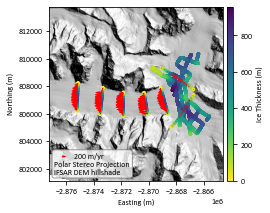

In [80]:
# plot points

fig, ax = plt.subplots(1,1, figsize=(3.7,3))

ax.imshow(hs,extent=hs_extent,cmap=plt.cm.gray)

vmin = np.nanmin(h)
vmax = np.nanmax(h)
c = ax.scatter(x,y,c=h,cmap = 'viridis_r',s=5, vmin=vmin, vmax=vmax)

idx = ~np.isnan(vx)
q = ax.quiver(x[idx],y[idx],vx[idx],vy[idx],color='r',width=.005)

ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.axis('equal')

xmin = np.nanmin(x)
xmax = np.nanmax(x)

ymin = np.nanmin(y)
ymax = np.nanmax(y)

xdiff = xmax - xmin
ydiff = ymax - ymin

corners = [(xmin,ymax), (xmax,ymax), (xmax, ymin), (xmin,ymin)]

xs = [p[0] for p in corners]
ys = [p[1] for p in corners]
ctr = (sum(xs) / len(corners), sum(ys) / len(corners))

diff = max(xdiff, ydiff)/2 + 1.5e3

ax.set_xlim([ctr[0]-diff-.5e3, ctr[0]+diff-.5e3])
ax.set_ylim([ctr[1]-diff, ctr[1]+diff])

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='4%', pad=0.05)
cbar = fig.colorbar(c, cax=cax, orientation='vertical', label='Ice Thickness (m)')

textstr = "\nPolar Stereo Projection\nIFSAR DEM hillshade"
props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray')

plt.rcParams.update({'font.size': 8})
# place a text box in upper left in axes coords
ax.text(0.03, 0.03, textstr, transform=ax.transAxes,
                horizontalalignment='left',verticalalignment='bottom',bbox=props, zorder=1)

ax.quiverkey(q,  X=0.1, Y=.14, U=200,
             label='200 m/yr', labelpos='E', coordinates = 'axes', zorder=1e10)

fig.tight_layout()
# plt.savefig('C:/Users/btober/OneDrive/Documents/pres/ruth/flux_gates.jpg',dpi=500)

Plot input thickness and surface speeds

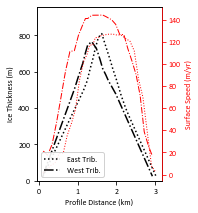

In [82]:
fig, a1 = plt.subplots(1,1, figsize=(2.8,3))
l1 = a1.plot(dist_e*1e-3, h_e, ':', color='k',label='East Trib.')
l2 = a1.plot(dist_w*1e-3, h_w, '-.', color='k',label='West Trib.')

a2 = a1.twinx()
a2.plot(dist_e*1e-3,np.sqrt(vx_e**2 + vy_e**2),':', color='red', lw=1)
a2.plot(dist_w*1e-3,np.sqrt(vx_w**2 + vy_w**2),'-.', color='red', lw=1)

a1.set_ylim([0, vmax])
a1.set_ylabel('Ice Thickness (m)')
a1.set_xlabel('Profile Distance (km)')
a2.set_ylabel('Surface Speed (m/yr)')
a2.yaxis.label.set_color('red')
a2.tick_params(axis='y', colors='red')
a2.spines['right'].set_color('red')

# added these three lines
lns = l1+l2
labs = [l.get_label() for l in lns]
a2.legend(lns, labs, loc='lower left', framealpha=.9)

# a1.legend(loc='lower left',framealpha=1).set_zorder(2)
fig.tight_layout()
# plt.savefig('C:/Users/btober/OneDrive/Documents/pres/ruth/trib_flux_in.jpg',dpi=300)

Manually freate flux get across which we'll invert for thickness

In [83]:
# endpoints, in same crs as velocity product
pt0 = (-2869140, 806074)
pt1 = (-2869140, 807782)

# generate evenly spaced points between endpoints
coords = equidistant_pts(pt0, pt1, step=vx_ds.transform[0])

In [84]:
# we want the unique velocity field cell indices which are crossed by the flux gate
# first get the indices of each coordinate pair in the raster
idxs = [vx_ds.index(pair[0],pair[1]) for pair in coords]
# now get the unique indices using dict.fromkeys() + list()
un_idxs = list(dict.fromkeys(idxs))
# get index of each unique index pair from the original list
un_idxs = [idxs.index(pair) for pair in un_idxs]
# now get unique coordinates
un_coords = [coords[id] for id in un_idxs]
# get x and y separate coords
x_out = np.asarray([x[0] for x in un_coords])
y_out = np.asarray([x[1] for x in un_coords])
# get bin widths
dx_out = np.diff(x_out)
dy_out = np.diff(y_out)
# get xy bin centers
x_out = (x_out[:-1] + x_out[1:])/2
y_out = (y_out[:-1] + y_out[1:])/2
# get x and y velocity components
coords = [(x,y) for x, y in zip(x_out,y_out)]
vx_out = np.asarray([x[0] for x in vx_ds.sample(coords)])
vy_out = np.asarray([x[0] for x in vy_ds.sample(coords)])
q_ovr_h =  np.abs((vx_out*dy_out) - (vy_out*dx_out)) * gamma     # [m^2/yr]

In [85]:
# get cumulative flux in upstream gate and cumulative velocity across downstream gate
q_ovr_h = np.sum(q_ovr_h)                                                               # [m^2/y]
# flux_in = np.sum(flux)                                                                # [m^3/y]
print(f"Average depth of downstream flux gate: {round(q_in / q_ovr_h)} m")              # [m]

Average depth of downstream flux gate: 629 m


Solve for thickness using deired glacier geometry - rectangle (average), ellipse, parbola

In [87]:
# iteratively solve for gate geometry based on input flux
a = 600     # starting apex depth
q_out = 0
step = 1
shape='parabola'
while q_out < q_in:

    out = discretized_flux(p0, p1, vx_ds, vy_ds, shape=shape, a=a)
    
    q_out = np.nansum(out[:,-1])

    # add to center depth until flux sums are roughly equal
    a+= step

a-=step
out = discretized_flux(p0, p1, vx_ds, vy_ds, shape=shape, a=a)
a-=step
print(f"a-value = {a} meters of ice")
print(f"Flux through {shape} = {round(q_out*1e-9,3)} cubic kilometers of ice per year")

a-value = 752 meters of ice
Flux through parabola = 0.218 cubic kilometers of ice per year


In [88]:
#stack x,y,vx,vy for plotting same scales
x = np.append(x_e,np.append(x_w,out[:,0]))
y = np.append(y_e,np.append(y_w,out[:,1]))
h = np.append(h_e,np.append(h_w,out[:,2]))
vx = np.append(vx_e,np.append(vx_w,out[:,3]))
vy = np.append(vy_e,np.append(vy_w,out[:,4]))

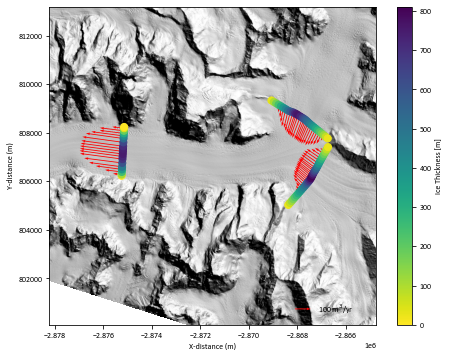

In [89]:
# plot points

fig, ax = plt.subplots(1,1, figsize=(6.5,5))

ax.imshow(hs,extent=hs_extent,cmap=plt.cm.gray)

q = ax.quiver(x,y,vx,vy,color='r',width=.0025)
c = ax.scatter(x,y,c=h,cmap = 'viridis_r',s=50, vmin=np.nanmin(h), vmax=np.nanmax(h))

fig.colorbar(c,label='Ice Thickness [m]')

ax.set_xlabel("X-distance (m)")
ax.set_ylabel("Y-distance (m)")
ax.axis('equal')

ax.quiverkey(q,  X=0.8, Y=.05, U=100,
             label='100 m$^3$/yr', labelpos='E', coordinates = 'axes')

xmin = min(np.nanmin(x_e), np.nanmin(x_e), np.nanmin(out[:,0]))
xmax = max(np.nanmax(x_e), np.nanmax(x_e), np.nanmax(out[:,0]))

ymin = min(np.nanmin(y_e), np.nanmin(y_e), np.nanmin(out[:,1]))
ymax = max(np.nanmax(y_e), np.nanmax(y_e), np.nanmax(out[:,1]))

corners = [(xmin,ymax), (xmax,ymax), (xmax, ymin), (xmin,ymin)]

xs = [p[0] for p in corners]
ys = [p[1] for p in corners]
ctr = (sum(xs) / len(corners), sum(ys) / len(corners))

diff = max(xdiff, ydiff)/2 + 1.5e3

ax.set_xlim([ctr[0]-diff-.5e3, ctr[0]+diff-.5e3])
ax.set_ylim([ctr[1]-diff, ctr[1]+diff])


fig.tight_layout()